In [133]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns

# Data Analysis

## Load Data

In [171]:
def get_data(offset , significance):
    df = pd.read_csv('../not_on_git/mw_cat/chandra_filtered_sources.csv' , index_col = 'name')
    df_id = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')[['offset' , 'class']]
    off = offset + 0.01
    df = pd.merge(df_id[df_id['offset']<off] , df , left_index=True , right_index =True , how='right')
    sig = significance
    df = df[df['significance']>sig]
    df = df.drop(columns = ['significance'  , 'offset' , 'ra' , 'dec', 'var_inter_hard_flag' , 'likelihood'])
    df = df.rename(columns = {
        'flux_aper_b' : 'b-csc' , 
        'flux_aper_h' : 'h-csc' ,
        'flux_aper_m': 'm-csc' ,
        'flux_aper_s': 's-csc' ,
        'flux_aper_u': 'u-csc' ,
    })
    df['class'] = df['class'].replace(np.nan , 'X')
    df = pd.merge(
        df , pd.read_csv('mw_cat/sdss.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/2mass_v2.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/wise_combined.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/galex_combined.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df = pd.merge(
        df , pd.read_csv('mw_cat/gaia.csv' , index_col='name') ,
        left_index=True , 
        right_index = True , 
        how = 'left'
    )
    df['bp-R'] = df['bp_mag']-df['rp_mag']
    df['g-J'] = df[ 'g_mag'] - df['Jmag']
    df['g-W2'] = df['g_mag'] - df['W2mag']
    df['bp-H'] = df['bp_mag'] - df[ 'Hmag']
    df['bp-W3'] = df['bp_mag'] - df['W3mag']
    df['rp-K'] = df['rp_mag'] - df['Kmag']
    df['J-H'] = df['Jmag'] - df['Hmag']
    df['J-W1'] = df['Jmag'] - df['W1mag']
    df['W1-W2'] = df['W1mag'] - df['W2mag']

    return df

In [172]:
from utilities import deets
df = get_data(offset=1.0 , significance=0)
deets(df , 1)

_____________________________________________________
------------------------------
Number of Objects : 277596
Number of Columns : 45
------------------------------


X         269893
STAR        2790
AGN         2395
YSO         1149
HMXB         748
ULX          211
CV           166
LMXB         143
PULSAR       101
Name: class, dtype: int64

_____________________________________________________


In [173]:
print(df.columns.to_list())

['class', 'gal_l', 'gal_b', 'var_flag', 'b-csc', 'h-csc', 'm-csc', 's-csc', 'u-csc', 'hard_hm', 'hard_hs', 'hard_ms', 'var_intra_index_b', 'var_intra_prob_b', 'ks_intra_prob_b', 'kp_intra_prob_b', 'var_inter_index_b', 'var_inter_prob_b', 'var_inter_sigma_b', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'fuv_mag', 'nuv_mag', 'g_mag', 'bp_mag', 'rp_mag', 'bp-R', 'g-J', 'g-W2', 'bp-H', 'bp-W3', 'rp-K', 'J-H', 'J-W1', 'W1-W2']


In [191]:
cd = [[ 'g_mag' , 'g-J'],
['g_mag' , 'bp-H'] , 
['g_mag' , 'bp-W3' ]  , 
['J' , 'g-W2'] , 
['J' , 'bp-H'] , 
['J' ,'bp-W3' ] , 
['W1' , 'rp-K'] , 
['W1' , 'bp-W3'] , 
['W2' , 'g-W2'] , 
['g-J' , 'Bp-W3'] , 
['g-J' , 'Bp-W3'] , 
['W1-W2' , 'bp-W3']]
cd = [tuple(el) for el in cd]
hard = ['hard_hm' , 'hard_ms']

In [201]:
cd = [
    [[ 'g_mag' , 'g-J'],['g_mag' , 'bp-H'] , ['g_mag' , 'bp-W3' ]]  , 
    [['Jmag' , 'g-W2'] , ['Jmag' , 'bp-H'] , ['Jmag' ,'bp-W3' ]] , 
    [['W1mag' , 'rp-K'] , ['W1mag' , 'bp-W3'] , ['W2mag' , 'g-W2']] , 
    [['g-J' , 'bp-W3'] , ['g-J' , 'bp-W3'] , ['W1-W2' , 'bp-W3']]
]

In [202]:
cl = ['AGN', 'STAR' , 'YSO' , 'HMXB' ,'LMXB' , 'CV' ,'ULX' , 'PULSAR' ]
fig , ax =  plt.subplots(nrows=4 , ncols=3 , figsize=(14,16))
#cl = np.reshape(cl , ax.shape)
#cdr = np.reshape(cd , ax.shape)
for i in range(4):
    for j in range(3):
        sns.displot(
            data = df , 
            x = cd[i][j][0] , 
            y = cd[i][j][1] , 
            hue = 'class' , 
            ax = ax[i][j] , 
            kind='kde'
        )
plt.show()

/home/kumaran/.local/lib/python3.6/site-packages/seaborn/distributions.py:2211: UserWarning:

`displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.



In [136]:
l#og-fb - bp-w3
G vs W 
G : H 
gaia vs hardness
#fx/fo important
G : g-j
G : G-W2 
G : Bp-H
G : Rp-k
G : Bp-W3
J : W3 
#J : Fx / Fo 
J : G-J 
J : G-W2 
J : Bp-H 
J : Bp-W3 
W1: rp-k
W1 : bp-w3 
W1 : G-W2 
#W1 : fx/fo 
W1 : G 
hr-hm : hr-ms 
G-J : Bp-W3 
Bp-H : G-J 
bp-w3 : w1-w2


,class,gal_l,gal_b,var_flag,b-csc,h-csc,m-csc,s-csc,u-csc,hard_hm,...,rp_mag,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J003935.9-732725,X,304.096050,-43.644346,0,0.000000e+00,7.141104e-15,1.529669e-15,0.000000e+00,0.000000e+00,0.231106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J003936.7-731249,X,304.116127,-43.887309,0,1.458552e-14,1.196830e-14,2.057132e-15,0.000000e+00,NaN,0.343535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004028.7-731106,X,304.031850,-43.919668,0,1.094959e-13,8.183634e-14,1.744202e-14,1.216939e-14,NaN,0.269831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004506.3-730056,X,303.575841,-44.104667,0,2.379848e-14,1.178519e-14,7.671868e-15,4.860946e-15,6.986833e-14,-0.106184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004659.0-731918,X,303.374710,-43.802532,0,0.000000e+00,0.000000e+00,1.259314e-15,6.172243e-16,8.098542e-14,0.151156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220613.7-495727,X,345.582863,-51.190099,0,3.452933e-14,2.859357e-14,7.190546e-15,0.000000e+00,NaN,-0.013741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220614.6-500951,X,345.272648,-51.119708,0,7.855447e-15,2.507461e-15,0.000000e+00,5.262109e-15,0.000000e+00,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220618.4-500554,X,345.365084,-51.152644,0,2.417635e-14,1.919246e-14,2.265201e-15,3.881337e-15,0.000000e+00,0.463460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
x = df[df['class']!='X']
y = x['class']
#x = x.drop(columns=['class'])
u = df[df['class']=='X']
u = u[u['var_flag']==1]
u = u.drop(columns = ['class'])

In [175]:
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 45
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 37844
Number of Columns : 44
_____________________________________________________


## Missing values

In [77]:
miss = []
for cl in y.unique():
#    cl = 'AGN'
    temp = x[x['class']==cl].drop(columns=['class'])
    miss.append((1-temp.isna().sum(axis=0) / len(temp)).to_frame(name=cl))
miss = pd.concat(miss , axis=1)
xd = x.drop(columns=['class'])
miss.insert(0 , 'overall' , (1-xd.isna().sum(axis=0) / len(xd)).to_list())
miss = miss[['overall' , 'AGN' , 'STAR' ,'YSO' , 'CV' , 'PULSAR' , 'HMXB'  , 'LMXB' ,'ULX']]

param_dict = {
    'SDSS' : ['umag' , 'gmag' , 'imag' , 'zmag' , 'rmag'] , 
    'WISE' : ['W1mag' , 'W2mag' , 'W3mag' , 'W4mag'] , 
    'GAIA' :['g_mag' , 'bp_mag' , 'rp_mag'] , 
    '2MASS' :['Jmag' , 'Hmag' , 'Kmag'] , 
    'GALEX' :['fuv_mag' , 'nuv_mag']
}
param_dict['inter-obs-var'] = ['var_inter_prob_b' , 'var_inter_sigma_b' , 'var_inter_index_b']
param_dict['intra-obs-var'] = ['var_intra_prob_b' , 'kp_intra_prob_b' , 'var_intra_index_b']
comb = ['WISE' , '2MASS' , 'GAIA' , 'SDSS' , 'GALEX' ,'inter-obs-var','intra-obs-var' ]
comb_df = []
for c in comb:
    comb_df.append(miss.loc[param_dict[c]].mean().to_frame(name=c).T)
comb_df = pd.concat(comb_df)
comb_df

sep_col = ['h-csc' ,'b-csc' , 'm-csc' , 'u-csc' ,'B-R' , 'G-J' , 'G-W2' , 'Bp-H' , 'Bp-W3' , 'Rp-K' , 'J-H' , 'J-W1' , 'W1-W2' ]
sep_df = miss.loc[sep_col]
sep_df
miss_comb_df = pd.concat([sep_df , comb_df]).sort_values(by='overall' , ascending=False)
miss_comb_df

,overall,AGN,STAR,YSO,CV,PULSAR,HMXB,LMXB,ULX
b-csc,0.967818,0.981627,0.952331,0.983333,0.781065,0.990476,0.986825,0.965035,0.985981
intra-obs-var,0.949322,0.985752,0.921837,0.945833,0.798817,0.952381,0.965744,0.874126,0.990654
m-csc,0.940074,0.968504,0.921486,0.949167,0.763314,0.942857,0.948617,0.804196,0.981308
h-csc,0.933909,0.972628,0.875920,0.979167,0.769231,0.904762,0.971014,0.958042,0.967290
GAIA,0.728113,0.728909,0.967403,0.715000,0.544379,0.371429,0.197628,0.223776,0.140187
B-R,0.728113,0.728909,0.967403,0.715000,0.544379,0.371429,0.197628,0.223776,0.140187
u-csc,0.688779,0.734158,0.662461,0.561667,0.597633,0.628571,0.799736,0.853147,0.785047
W1-W2,0.681628,0.869516,0.801963,0.550000,0.147929,0.085714,0.229249,0.139860,0.154206
WISE,0.678052,0.869516,0.793901,0.545000,0.147929,0.085714,0.229249,0.139860,0.154206
2MASS,0.582244,0.262842,0.959692,0.910000,0.301775,0.209524,0.115942,0.090909,0.079439


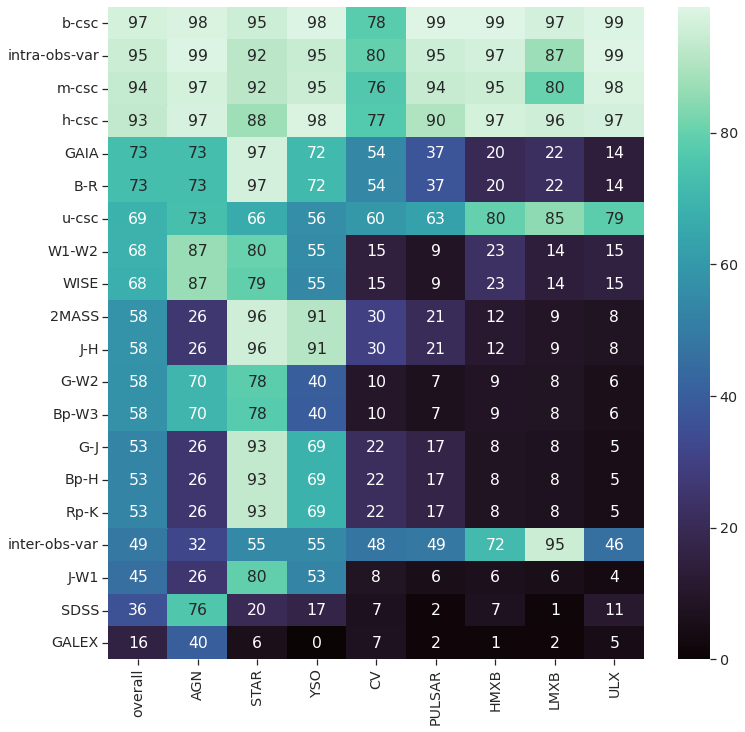

In [78]:
import seaborn as sns
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="ticks")
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
sns.heatmap(miss_comb_df*100 , ax=ax , annot=True , fmt='.0f' , cmap='mako')
plt.xticks(rotation=90)
#plt.savefig('final_plots/missing_features.eps' , format='eps')
#plt.savefig('final_plots/missing_features.jpg' , format='jpg')
plt.show()

# Train Classifier

In [176]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

In [177]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

### Normalize 

In [178]:
from sklearn.preprocessing import MinMaxScaler
norm  = MinMaxScaler(feature_range=(0,10))
xn = norm.fit_transform(x.drop(columns=['class']))
xn = pd.DataFrame(xn , columns=x.drop(columns=['class']).columns.to_list() , index = x.index.to_list())
un = norm.transform(u)
un = pd.DataFrame(un , columns = u.columns.to_list() , index = u.index.to_list())

In [179]:
xn

,gal_l,gal_b,var_flag,b-csc,h-csc,m-csc,s-csc,u-csc,hard_hm,hard_hs,...,rp_mag,bp-R,g-J,g-W2,bp-H,bp-W3,rp-K,J-H,J-W1,W1-W2
2CXO J005634.9-732630,8.400731,2.546960,0.0,0.009376,0.014046,0.010123,0.000000,0.000000e+00,6.56875,10.00000,...,8.030327,3.501902,2.436288,3.088457,3.173957,3.631708,2.813521,4.109840,4.094203,4.567045
2CXO J010309.0-724455,8.381088,2.509465,0.0,0.009497,0.004543,0.007445,0.006731,2.310221e-05,2.90625,0.50625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.365370,4.498702,4.460307
2CXO J010413.1-731905,8.379535,2.541529,0.0,0.023216,0.004060,0.009970,0.022041,0.000000e+00,3.58125,0.35000,...,3.951549,2.961170,1.837307,2.853618,2.095379,2.129103,1.922021,2.947368,4.226693,4.489660
2CXO J164659.8-455525,9.430220,4.965304,0.0,0.014020,0.024346,0.002532,0.000353,0.000000e+00,8.96875,10.00000,...,5.995487,8.995957,6.282667,8.350315,8.871900,7.187541,7.525688,5.180778,6.556349,5.969313
2CXO J164818.2-461039,9.428908,4.946457,0.0,0.016615,0.000000,0.021100,0.014550,NaN,0.00000,0.00000,...,3.547036,2.533029,1.666508,2.811300,1.790080,2.349007,1.939337,2.803966,4.264547,4.527018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J073751.2-303940,6.812125,4.738073,0.0,0.024611,0.005640,0.029337,0.017930,8.598711e-06,2.17500,0.61875,...,8.276687,2.764355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J073756.3-303557,6.810865,4.740655,10.0,0.005672,0.002567,0.007325,0.003914,1.436520e-06,2.77500,0.85625,...,3.884456,2.136725,1.072583,2.251638,1.128902,1.561221,1.233326,2.459191,4.073653,4.454970
2CXO J073810.2-303824,6.812530,4.741969,0.0,0.005850,0.000000,0.001806,0.006156,4.128000e-06,0.61250,0.00000,...,3.528270,2.687928,1.596306,2.621639,1.763759,1.901717,1.666024,2.759725,4.141791,4.466978
2CXO J113218.2-301952,7.869974,6.640436,10.0,0.014563,0.010783,0.027946,0.004017,2.316437e-07,3.79375,3.49375,...,6.095504,5.920630,6.303944,5.775119,6.474540,5.248764,5.597140,3.292143,4.401904,5.027352


In [181]:
#xn = x.drop(columns=['class'])
y = x['class']

In [182]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
gamma = 0.016
cl_weight = calc_weight(gamma , y)
clf = lgb.LGBMClassifier(n_estimators = 80 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM' , clf ,gamma , xn,y)
model.validate(k=20)
model.train()

>>> GOING for 1 / 20 Iteration FOLD
>>> GOING for 2 / 20 Iteration FOLD
>>> GOING for 3 / 20 Iteration FOLD
>>> GOING for 4 / 20 Iteration FOLD
>>> GOING for 5 / 20 Iteration FOLD
>>> GOING for 6 / 20 Iteration FOLD
>>> GOING for 7 / 20 Iteration FOLD
>>> GOING for 8 / 20 Iteration FOLD
>>> GOING for 9 / 20 Iteration FOLD
>>> GOING for 10 / 20 Iteration FOLD
>>> GOING for 11 / 20 Iteration FOLD
>>> GOING for 12 / 20 Iteration FOLD
>>> GOING for 13 / 20 Iteration FOLD
>>> GOING for 14 / 20 Iteration FOLD
>>> GOING for 15 / 20 Iteration FOLD
>>> GOING for 16 / 20 Iteration FOLD
>>> GOING for 17 / 20 Iteration FOLD
>>> GOING for 18 / 20 Iteration FOLD
>>> GOING for 19 / 20 Iteration FOLD
>>> GOING for 20 / 20 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.987056 |          0.957861 |   0.972239 |
| CV      |       0.536145 |          0.622378 |   0.576052 |
| HMXB    |       0.9

In [110]:
model.train()

In [111]:
model.result['res_table'].to_csv('temp_res_comp/train_prob/new-data_lightGBM.csv')
#model.train()
model.save('models/lightGBM-new-final.pkl')

# Application

In [112]:
import joblib 
model = joblib.load('models/lightGBM-new-final.pkl')
clf = model.clf

In [113]:
deets(xn)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 8110
Number of Columns : 44
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 37778
Number of Columns : 44
_____________________________________________________


In [114]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.173449,0.012852,0.740774,0.001522,0.011126,0.038538,0.019950,0.001789
2CXO J005449.0-725128,0.250924,0.030238,0.627890,0.000294,0.005449,0.028711,0.055478,0.001016
2CXO J010049.1-731526,0.013147,0.000237,0.058350,0.000086,0.893109,0.003012,0.031907,0.000151
2CXO J010049.8-731045,0.058562,0.020247,0.748806,0.001114,0.003907,0.037349,0.128934,0.001080
2CXO J010647.7-730940,0.023876,0.035080,0.154358,0.000912,0.688078,0.091744,0.005282,0.000671
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.024961,0.021465,0.564430,0.000102,0.230233,0.002295,0.156159,0.000355
2CXO J220508.3-495935,0.034827,0.011383,0.888330,0.000176,0.012410,0.001527,0.051121,0.000226
2CXO J220544.0-495505,0.065312,0.008213,0.917737,0.000146,0.000792,0.004264,0.003252,0.000285
2CXO J220555.6-500837,0.006322,0.006187,0.951230,0.000316,0.000842,0.000765,0.034230,0.000108


In [115]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,0.740774,0.567325,0.173449,0.012852,0.740774,0.001522,0.011126,0.038538,0.019950,0.001789
2CXO J005449.0-725128,HMXB,0.627890,0.376966,0.250924,0.030238,0.627890,0.000294,0.005449,0.028711,0.055478,0.001016
2CXO J010049.1-731526,PULSAR,0.893109,0.834759,0.013147,0.000237,0.058350,0.000086,0.893109,0.003012,0.031907,0.000151
2CXO J010049.8-731045,HMXB,0.748806,0.619872,0.058562,0.020247,0.748806,0.001114,0.003907,0.037349,0.128934,0.001080
2CXO J010647.7-730940,PULSAR,0.688078,0.533721,0.023876,0.035080,0.154358,0.000912,0.688078,0.091744,0.005282,0.000671
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.564430,0.334197,0.024961,0.021465,0.564430,0.000102,0.230233,0.002295,0.156159,0.000355
2CXO J220508.3-495935,HMXB,0.888330,0.837209,0.034827,0.011383,0.888330,0.000176,0.012410,0.001527,0.051121,0.000226
2CXO J220544.0-495505,HMXB,0.917737,0.852425,0.065312,0.008213,0.917737,0.000146,0.000792,0.004264,0.003252,0.000285


In [116]:
u_df['class'].value_counts()

AGN       10327
YSO        9754
HMXB       5545
ULX        3562
STAR       3020
PULSAR     2987
CV         2362
LMXB        221
Name: class, dtype: int64

In [117]:
ui = pd.read_csv('flags/chandra_all_flags.csv' , index_col='name')[['ra', 'dec']]
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True , how='left')
u_pos

,class,prob,ra,dec
name,,,,
2CXO J004829.5-732959,HMXB,0.740774,12.123114,-73.499901
2CXO J005449.0-725128,HMXB,0.627890,13.704345,-72.857987
2CXO J010049.1-731526,PULSAR,0.893109,15.204787,-73.257463
2CXO J010049.8-731045,HMXB,0.748806,15.207831,-73.179381
2CXO J010647.7-730940,PULSAR,0.688078,16.699164,-73.161175
...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.564430,331.138121,-49.987838
2CXO J220508.3-495935,HMXB,0.888330,331.284642,-49.993301
2CXO J220544.0-495505,HMXB,0.917737,331.433541,-49.918280


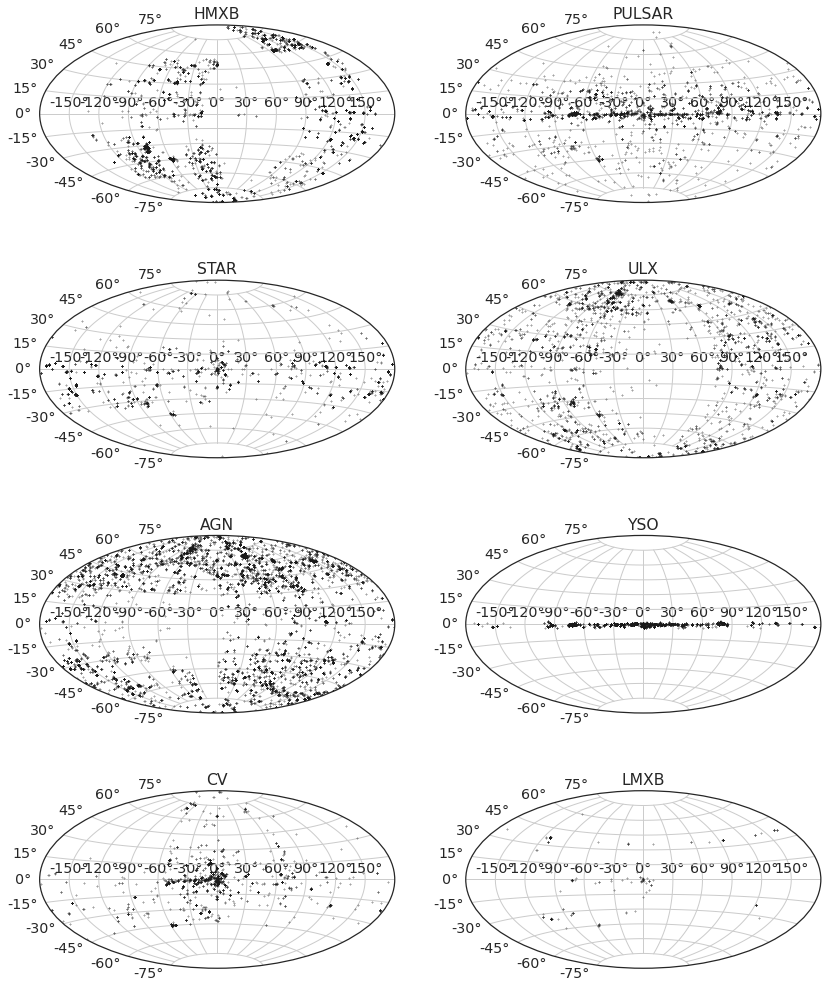

In [118]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
classes = u_df['class'].unique()
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
#fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
#plt.savefig('plots/all_src_pred/lightgbm_non-var.jpg')
plt.show()

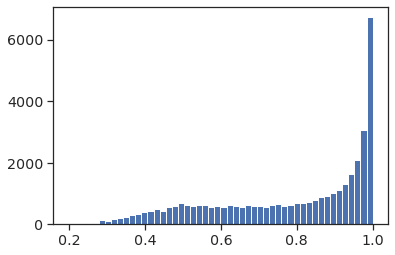

0.9839397325968233

In [119]:
x ,y ,z = plt.hist(u_df['prob'] ,bins=50)
plt.grid()
plt.show()
mode = y[np.argmax(x)]
mode

In [120]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                u_df[u_df['prob']>0.6]['class'].value_counts(),
                u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                u_df[u_df['prob']>0.9]['class'].value_counts(),
                #u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax' , f"Most probable > {mode :.2f}" ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9']
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   Most probable > 0.98 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |
|:--------|---------:|-----------------------:|------:|------:|------:|------:|------:|
| AGN     |    10327 |                   2734 |  9493 |  8690 |  7888 |  6983 |  5680 |
| YSO     |     9754 |                   2376 |  9210 |  8700 |  8057 |  7278 |  5921 |
| HMXB    |     5545 |                    743 |  4490 |  3708 |  2989 |  2398 |  1760 |
| ULX     |     3562 |                    168 |  2970 |  2460 |  2037 |  1546 |   921 |
| STAR    |     3020 |                    333 |  2161 |  1703 |  1313 |   977 |   660 |
| PULSAR  |     2987 |                    193 |  2397 |  1986 |  1618 |  1232 |   747 |
| CV      |     2362 |                    122 |  1744 |  1403 |  1073 |   766 |   425 |
| LMXB    |      221 |                     60 |   172 |   138 |   111 |    96 |    77 |


In [121]:
print(u_df_num.to_latex(bold_rows=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Argmax &  Most probable > 0.98 &   0.5 &   0.6 &   0.7 &   0.8 &   0.9 \\
\textbf{class } &         &                       &       &       &       &       &       \\
\midrule
\textbf{AGN   } &   10327 &                  2734 &  9493 &  8690 &  7888 &  6983 &  5680 \\
\textbf{YSO   } &    9754 &                  2376 &  9210 &  8700 &  8057 &  7278 &  5921 \\
\textbf{HMXB  } &    5545 &                   743 &  4490 &  3708 &  2989 &  2398 &  1760 \\
\textbf{ULX   } &    3562 &                   168 &  2970 &  2460 &  2037 &  1546 &   921 \\
\textbf{STAR  } &    3020 &                   333 &  2161 &  1703 &  1313 &   977 &   660 \\
\textbf{PULSAR} &    2987 &                   193 &  2397 &  1986 &  1618 &  1232 &   747 \\
\textbf{CV    } &    2362 &                   122 &  1744 &  1403 &  1073 &   766 &   425 \\
\textbf{LMXB  } &     221 &                    60 &   172 &   138 &   111 &    96 &    77 \\
\bottomrule
\end{tabular}



In [122]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
#cl.remove('LMXB')
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

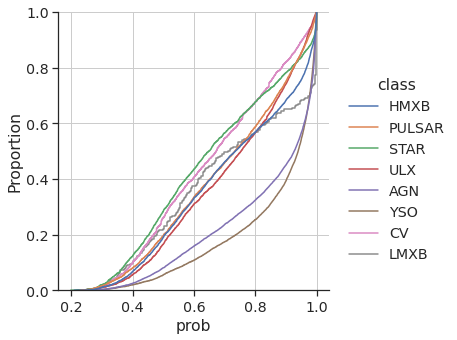

In [123]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()

In [124]:
u_conf = u[u_df['prob']>0.98]
u_conf

,gal_l,gal_b,var_flag,b-csc,h-csc,m-csc,s-csc,u-csc,hard_hm,hard_hs,...,rp_mag,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J011105.6-730106,300.937666,-44.033723,1,3.050130e-14,1.434232e-14,1.296133e-15,1.304980e-14,0.000000e+00,0.502186,-0.600874,...,8.960229,0.586417,0.751436,0.976436,1.169646,1.206646,0.608229,0.201,0.266,-0.041
2CXO J171938.0-355912,351.104697,0.737766,1,3.444959e-15,3.787304e-15,NaN,NaN,NaN,0.999375,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J171943.9-355454,351.175168,0.762467,1,5.771630e-16,0.000000e+00,7.960918e-16,NaN,NaN,-0.999375,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J172032.1-354234,351.436843,0.746385,1,9.567340e-15,7.391813e-15,2.596464e-15,0.000000e+00,NaN,0.173641,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J172032.1-354323,351.425694,0.738649,1,3.325596e-15,2.042910e-15,1.223466e-15,0.000000e+00,NaN,0.047470,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J113209.8-302106,283.293645,29.479137,1,2.305849e-15,1.924246e-15,4.593868e-16,NaN,NaN,0.316052,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J113223.2-302439,283.369008,29.440145,1,4.340756e-15,3.567133e-15,8.981958e-16,0.000000e+00,NaN,0.153654,0.999375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J223943.8-053429,61.491565,-51.979333,1,4.532208e-14,2.568541e-14,6.823947e-15,1.036159e-14,NaN,0.106184,-0.287320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
y_p = u_df['class']
cl = ['AGN' ,'STAR' , 'YSO' , 'HMXB' , 'LMXB' , 'ULX' ,'CV' ,'PULSAR']
sns.set(font_scale=1.2, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")
f = 'kp_intra_prob_b'
f = 'var_inter_prob_b'

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



KeyError: False

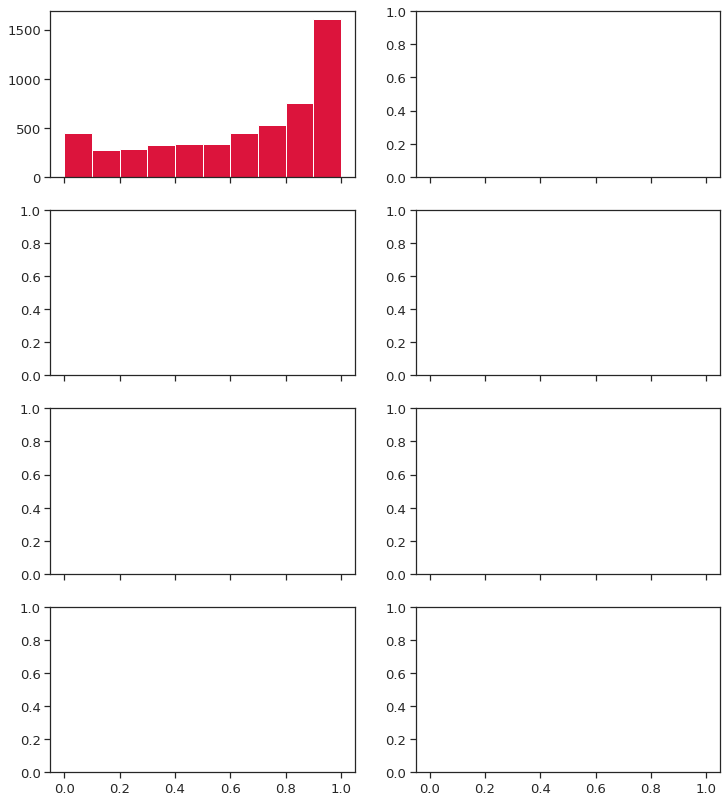

In [132]:
fig , ax = plt.subplots(nrows=4, ncols=2 , figsize=(12,14) , sharex=True)
#plt.hist(x['kp_intra_prob_b'])
cl = np.reshape(cl , ax.shape)
for i in range(4):
    for j in range(2):
        temp = u[y_p==cl[i][j]]
        ax[i][j].hist(temp[f] , label = 'Unidentified sources' , color='crimson' , )
        temp = xn[y==cl[i][j]]
        #display(temp)
        ax[i][j].hist(temp[f] , label = 'Training sources' , color='black', )
        ax[i][j].set_title(cl[i][j])
        ax[i][j].legend()
        #ax[i][j].set_xlabel('var_intra_prob_b')
ax[3][0].set_xlabel(f)
ax[3][1].set_xlabel(f)

#plt.savefig('final_plots/var-src-hist.eps' , format='eps')
plt.show()